## Data Importing & Exploration

In [81]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
import os
#import glob

In [82]:
# Reading in a single image and label
img = nib.load('./Raw_Data/imagesTr/hippocampus_001.nii.gz')
label = nib.load('./Raw_Data/labelsTr/hippocampus_001.nii.gz')

# Convert image to Numpy format
img_np = img.get_fdata()
label_np = label.get_fdata()



#### Note:

More information regarding the NifTI file format & metadata can be found <a href='https://brainder.org/2012/09/23/the-nifti-file-format/'>here</a>.

Text(0.5, 1.0, 'Label of Sagittal slice 14')

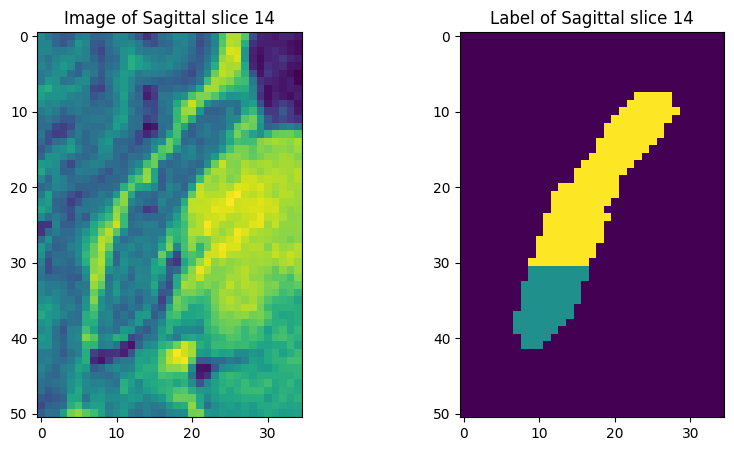

In [83]:
# Visualize the sagital slice 14
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img_np[14,:,:])
axes[0].set_title('Image of Sagittal slice 14')

axes[1].imshow(label_np[14,:,:])
axes[1].set_title('Label of Sagittal slice 14')

### Image Information, Volumetric & Area Calculation
We want to understand the data format of a single image (really a set of images that comprise a 3D representation).

** Adapted from ElliotY-ML's <a href="https://github.com/ElliotY-ML/Hippocampus_Segmentation_MRI/tree/master">Hippocampus_Segmentation_MRI Repo</a>



In [84]:
img_np[1]

# img values need to be normalized to range[0, 1] 

array([[ 39.,  30.,  33., ..., 101., 101., 100.],
       [ 38.,  30.,  31., ..., 103., 100., 101.],
       [ 42.,  29.,  28., ..., 103., 106., 100.],
       ...,
       [100., 100., 102., ...,  22.,  33.,  36.],
       [ 98.,  99., 105., ...,  26.,  36.,  41.],
       [ 91.,  90.,  90., ...,  29.,  38.,  44.]])

In [85]:
img_np = img_np/np.max(img_np)
label_np = label_np/np.max(label_np)

img_np[1]

array([[0.28057554, 0.21582734, 0.23741007, ..., 0.72661871, 0.72661871,
        0.71942446],
       [0.27338129, 0.21582734, 0.22302158, ..., 0.74100719, 0.71942446,
        0.72661871],
       [0.30215827, 0.20863309, 0.20143885, ..., 0.74100719, 0.76258993,
        0.71942446],
       ...,
       [0.71942446, 0.71942446, 0.73381295, ..., 0.15827338, 0.23741007,
        0.25899281],
       [0.70503597, 0.71223022, 0.75539568, ..., 0.18705036, 0.25899281,
        0.29496403],
       [0.65467626, 0.64748201, 0.64748201, ..., 0.20863309, 0.27338129,
        0.31654676]])

Text(0.5, 1.0, 'Label of Sagittal slice 14')

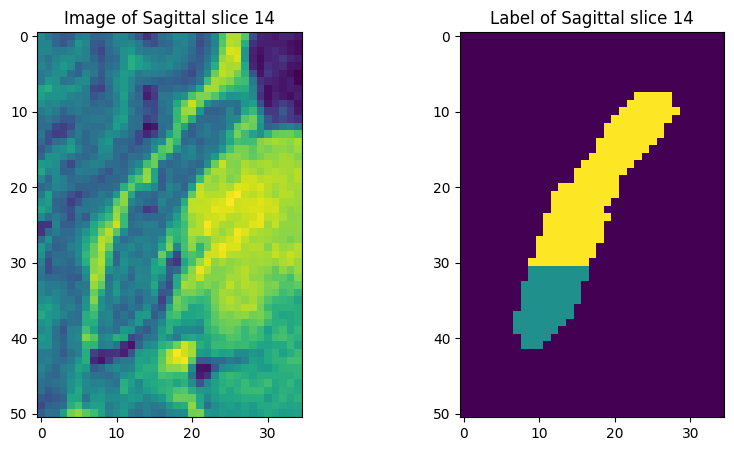

In [86]:
# Visualize the sagital slice 14 - they should be the same as above!!!
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img_np[14,:,:])
axes[0].set_title('Image of Sagittal slice 14')

axes[1].imshow(label_np[14,:,:])
axes[1].set_title('Label of Sagittal slice 14')

In [87]:
# **
# We know the images are in NIFTI format (.nii), but lets load in the metadata to confirm, and also get some spatial information about the images we are dealing with. 
# This will help with the later task of determining the hippocampal slice area in mm^2

print(f'Img: {img.header} \n')
print(f'Label: {label.header}')

Img: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 51 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          :

* xyzt_units indicate the unit of measurement for dim. 10 in binary -> 2. 2 corresponds to unit: mm
* pixdim indicate the voxel dimensions of the scan.
    * Voxel Dims: [1, 1, 1, 1, 1, 0, 0, 0]
        * First value (1) is unused
        * Next 3 values (1, 1, 1) specify the size of the voxels along each dimension.
        * Last 3 values (0, 0, 0) are used for timing in fMRI scans - not applicable.

#### Note:

Knowing that one voxel dimension translates to a slice, and that each voxel represents one mm^3 in space makes out subsequent work much easier! No need to convert values to get the right units.

In [88]:
# Volume of first HPC:

voxel_volume = np.prod(label.header.get_zooms()[:3])
num_voxels = np.count_nonzero(label_np)

print(f'Total volume of the HPC is: {voxel_volume * num_voxels} mm^3')

slice_voxels = np.count_nonzero(label_np[14,:,:])

print(f'Total area of the 14th sagittal slice of the HPC is: {1 * slice_voxels} mm^2')

Total volume of the HPC is: 2948.0 mm^3
Total area of the 14th sagittal slice of the HPC is: 250 mm^2


### Loading all Sagittal Slices

In [89]:
# Directories containing the images and labels
image_dir = './Raw_Data/imagesTr'
label_dir = './Raw_Data/labelsTr'

# Function to load NIfTI images
def load_nifti_image(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Lists to store images and labels
images = []
labels = []

slice_images = []
slice_labels = []

# Iterate through the files in the directories
for file_name in sorted(os.listdir(image_dir)):
    if file_name.endswith('.nii.gz'):
        image_path = os.path.join(image_dir, file_name)
        label_path = os.path.join(label_dir, file_name)  # Assuming the label file has the same name
        
        # Load the images and labels & standardize them to rage[0, 1]
        img_np = load_nifti_image(image_path)
        img_np = img_np/np.max(img_np)
        label_np = load_nifti_image(label_path)
        label_np = label_np/np.max(label_np)
        

        # Append the images and labels to the list
        images.append(img_np)
        labels.append(label_np)

        # Extract the 14th sagittal slice
        slice_img = img_np[14, :, :]
        slice_label = label_np[14, :, :]
        
        # Append the slices to the lists
        slice_images.append(slice_img)
        slice_labels.append(slice_label)

assert(len(slice_images) == len(slice_labels))





### Visualization of Slice Subset

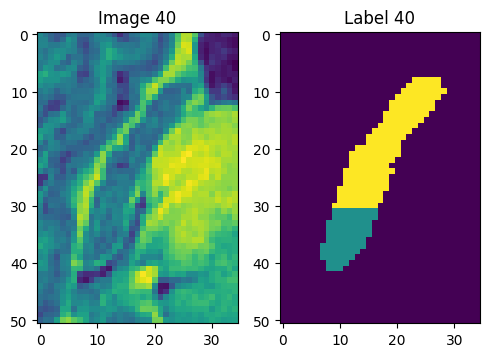

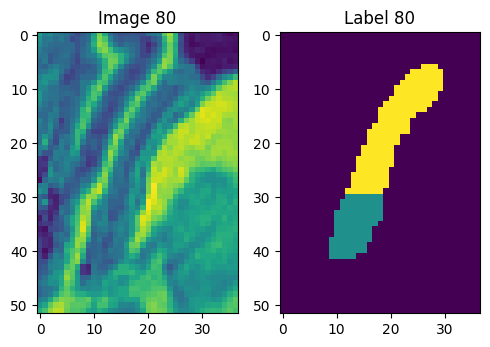

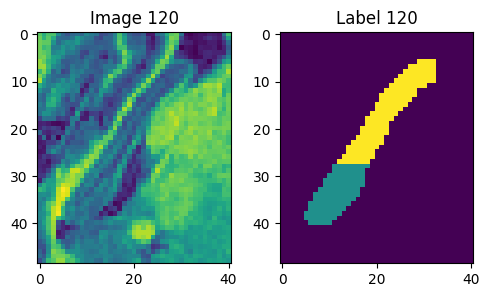

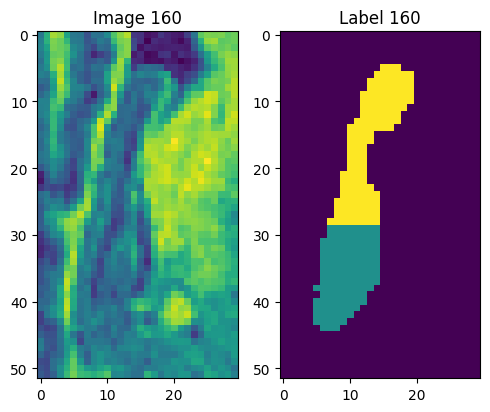

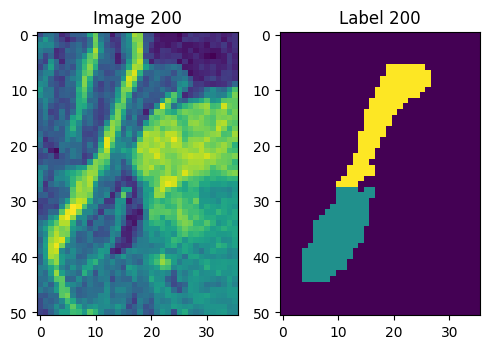

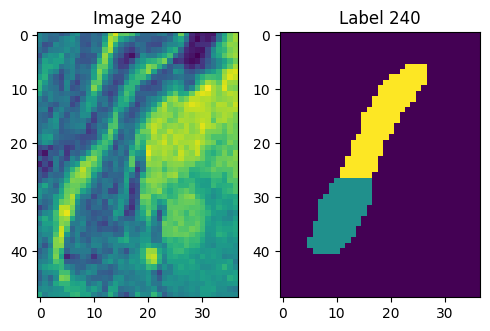

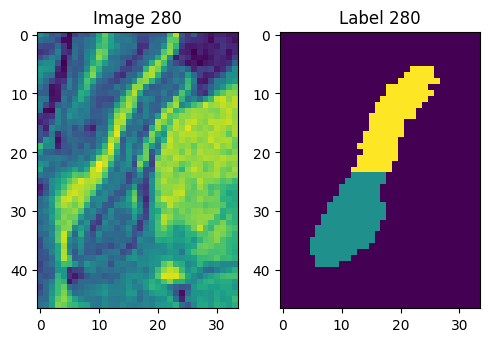

In [90]:
# Function to plot the 14th sagittal slice of images and labels
def plot_slices(images, labels, step):
    num_images = len(images)

    for i in range(0, num_images, step):
        fig, axes = plt.subplots(1, 2, figsize=(5, 5))
        
        # Plot the image slice
        axes[0].imshow(images[i])
        axes[0].set_title(f'Image {i + step}')
        
        # Plot the label slice
        axes[1].imshow(labels[i])
        axes[1].set_title(f'Label {i + step}')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

# Plot the 14th sagittal slice of each image and label
plot_slices(slice_images, slice_labels, 40)

#### Note:
At this point, we have loaded the 14th sagital slice of each training image and the associated mask. We are next going to ensure every mask lines up in its dimension with the associated image. Masks which do not have the same dimensions cannot be used for training, and the image must be discarded. 

Then, we will set aside a subset (60) of the training images.

In [91]:
if len(images) != len(labels):
    print("The lists do not have the same number of elements.")
else:
    # Iterate over both lists simultaneously
    for i, (array1, array2) in enumerate(zip(slice_images, slice_labels)):
        if array1.shape != array2.shape:
            print(f"Arrays at index {i} do not have the same shape: {array1.shape} != {array2.shape}")
        else:
            # Check each individual image array within the multidimensional array
            all_shapes_match = []
            for j in range(array1.shape[0]):
                for k in range(array1.shape[1]):
                    if array1[j, k].shape != array2[j, k].shape:
                        print(f"Image arrays at index [{i}][{j}][{k}] do not have the same shape: {array1[j, k].shape} != {array2[j, k].shape}")
                        all_shapes_match.append(False)
                    else:
                        all_shapes_match.append(True)
        all(all_shapes_match)

<p>Now we have verified that each corresponding mask and image is the same dimension for sagittal slice #14!</p>

In [92]:
# Spitting off data for evaluation
random.seed(122)
training_indices = sorted(random.sample(list(range(len(slice_images))), 200))
testing_indices = sorted([i for i in list(range(len(slice_labels))) if i not in training_indices])

training_images = [slice_images[i] for i in training_indices]
training_labels = [slice_labels[i] for i in training_indices]
val_images = [slice_images[i] for i in testing_indices]
val_labels = [slice_labels[i] for i in testing_indices]


assert(len(training_images) == len(training_labels) and len(val_images) == len(val_labels))

## Model Construction

In [93]:
# Imports
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.optimizers.legacy import Adam

### Image Pre-Processing

In [94]:
# Current image sizes
count = 0
for image in training_images:
    if count <= 10:
        print(image.shape)
        count = count + 1
    else:
        None


(51, 35)
(52, 35)
(52, 38)
(52, 34)
(47, 40)
(48, 40)
(50, 31)
(50, 40)
(47, 41)
(46, 43)
(51, 35)


Resnet-50 takes in images of 224x224 px. Our current imagesets are varied in their dimensions & much smaller.

In [95]:
def resize_and_pad_image(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate the scaling factor while maintaining aspect ratio
    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a new image of the target size with padding
    pad_h = (target_h - new_h) // 2
    pad_w = (target_w - new_w) // 2

    # Initialize a new array with the target size and pad the resized image into it
    if len(image.shape) == 3:  # Color image
        padded_image = np.zeros((target_h, target_w, 3), dtype=image.dtype)
    else:  # Grayscale image
        padded_image = np.zeros((target_h, target_w), dtype=image.dtype)

    padded_image[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_image

    return padded_image

def resize_and_pad_images(image_list):
    processed_images = []
    for image in image_list:
        processed_image = resize_and_pad_image(image)
        processed_images.append(processed_image)
    return processed_images


training_images = resize_and_pad_images(training_images)
training_labels = resize_and_pad_images(training_labels)
val_images = resize_and_pad_images(val_images)
val_labels = resize_and_pad_images(val_labels)


In [72]:
# Ideally, we would save our images to a folder. (add code here)

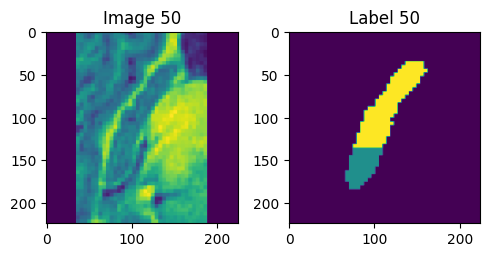

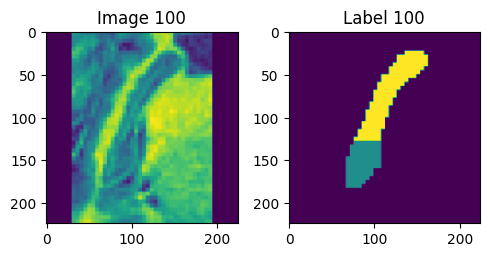

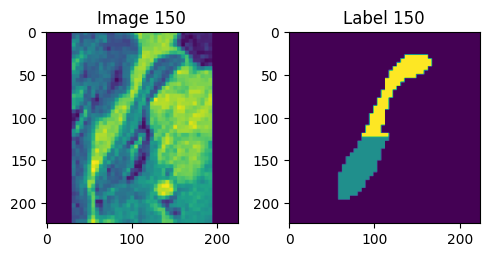

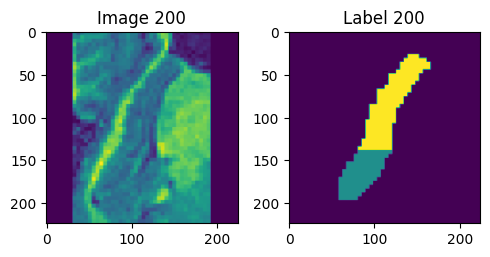

In [73]:
plot_slices(training_images, training_labels, step = 50)

In [74]:
# image shapes
training_images[1].shape

(224, 224)

Images are now stored in a list as standardized 224x224 images with variable padding. This may affect the model's learning rate, as it must learn that the padding is not relevant to the prediction, and the padding varies from image to image. 

When doing a segmentation/calculation that has image-bound scale information (washer of fixed size), this preprocessing step will not impact our ability to calculate values based on the image. In this case, though, since the voxel information has been lost to scaling, it would be difficult to calculate area. This could be fixed by saving our images initial scale & downscaling the segmented images before calculating volume/area.

We still need to preprocess our list of images so they are in the correct format (np array of 4d tensors).

In [97]:
def image_list_to_tensor(image_list, is_label = False):
    images_4d = np.stack(image_list, axis=0)
    
    if is_label:
        # Ensure the binary mask has shape (num_samples, 224, 224, 1)
        images_4d = images_4d[..., np.newaxis]
    else:
        # Ensure the image has shape (num_samples, 224, 224, 3)
        images_4d = images_4d[...,np.newaxis]
        images_4d = np.repeat(images_4d, 3, axis=-1)
    
    # Convert to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images_4d, dtype=tf.float32)
    return images_tensor


training_images = image_list_to_tensor(training_images)
training_labels = image_list_to_tensor(training_labels, is_label=True)
val_images = image_list_to_tensor(val_images)
val_labels = image_list_to_tensor(val_labels, is_label=True)

val_images.shape

TensorShape([60, 224, 224, 3])

### Next, lets try constructing a a pre-trained model, training it with our images, and evaluating the performance.

** from https://idiotdeveloper.com/step-by-step-guide-to-resnet50-unet-in-tensorflow/

In [20]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs) # load in the pre-trained model to use as the encoder
 
    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512) initial input layer
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)
 
    """ Bottleneck """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
 
    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

input_shape = (224, 224, 3)
model = build_resnet50_unet(input_shape)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, batch_size = 2, epochs=2, validation_split=0.2)

Epoch 1/2
80/80 [==============================] - 291s 4s/step - loss: 0.1781 - accuracy: 0.9123 - val_loss: 0.3137 - val_accuracy: 0.8917
Epoch 2/2
80/80 [==============================] - 302s 4s/step - loss: 0.0851 - accuracy: 0.9378 - val_loss: 0.2700 - val_accuracy: 0.8917


In [105]:
val_images.shape

TensorShape([60, 224, 224, 3])

2/2 [==============================] - 22s 10s/step


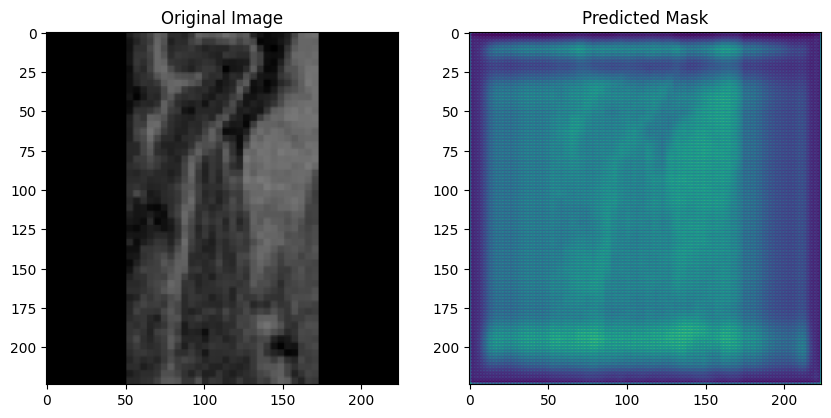

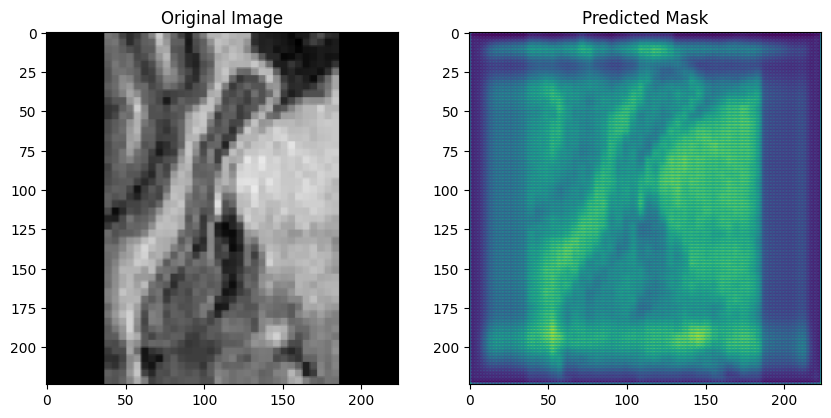

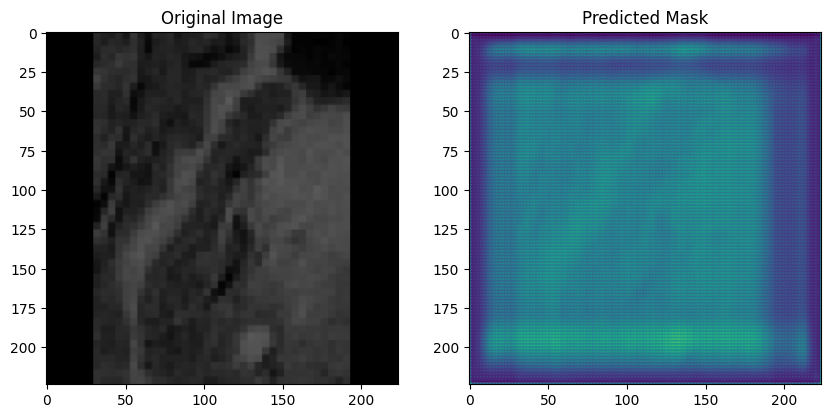

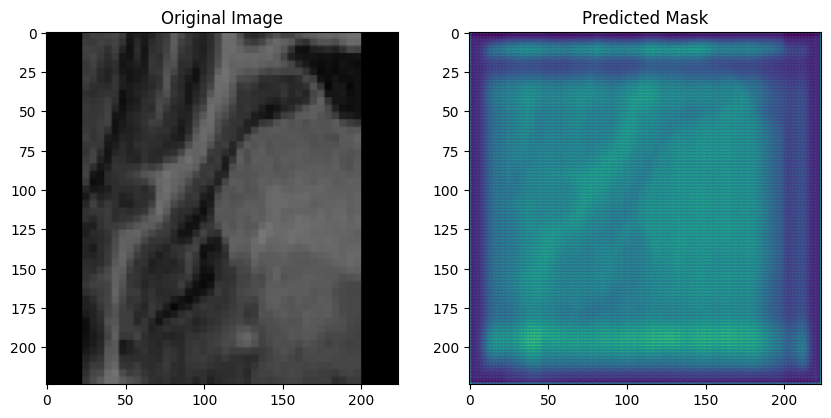

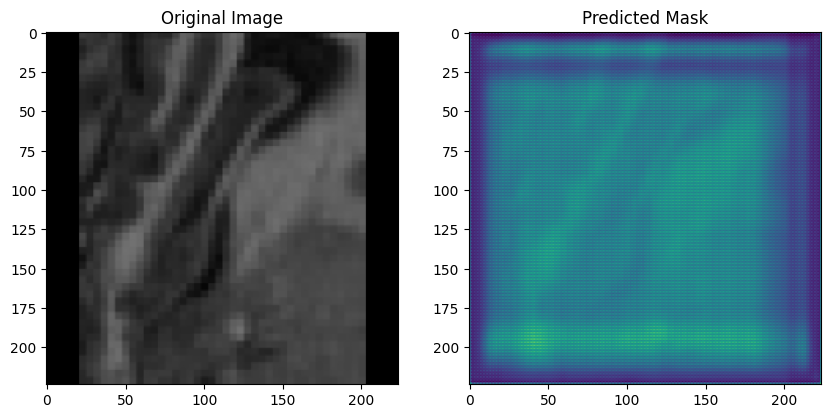

In [110]:

# Predict the segmentation masks
def predict_masks(model, val_images):
    """
    Predict segmentation masks for a batch of images.
    Args:
        model (tf.keras.Model): Trained model.
        val_images (tf.Tensor): Tensor containing the validation images.
    
    Returns:
        np.array: Array of predicted segmentation masks.
    """
    predictions = model.predict(val_images)  # Binarize the output masks
    return predictions

# Predict masks for the validation images
predicted_masks = predict_masks(model, val_images)

# Display a few images with their predicted masks
def display_images_and_masks(val_images, predicted_masks, num_images=5):
    """
    Displays the original images and their predicted masks.
    Args:
        val_images (tf.Tensor): Tensor containing the original images.
        predicted_masks (np.array): Array of predicted segmentation masks.
        num_images (int): Number of images to display.
    """
    for i in range(num_images):
        original_image = val_images[i].numpy()
        pred_mask = predicted_masks[i]
        mask = val_labels[i].numpy()
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image)
        
        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask)

        plt.show()

# Display the first 5 images and their predicted masks
display_images_and_masks(val_images, predicted_masks, num_images=5)